In [ ]:
!pip install presidio-analyzer presidio-anonymizer spacy
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 32.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import yaml

# Define the configuration as a Python dictionary
config = {
    'nlp_engine_name': 'spacy',
    'models': [
        {
            'lang_code': 'it',
            'model_name': 'it_core_news_sm'
        }
    ],
    'ner_model_configuration': {
        'model_to_presidio_entity_mapping': {
            'PER': 'PERSON',
            'LOC': 'LOCATION',
            'GPE': 'LOCATION',
            'ORG': 'ORGANIZATION',
            'DATE': 'DATE_TIME',
            'TIME': 'DATE_TIME',
            # 'MISC': 'MISCELLANEOUS'

        },
        'labels_to_ignore': [
            'CARDINAL',
            'EVENT',
            'LANGUAGE',
            'LAW',
            'MONEY',
            'ORDINAL',
            'PERCENT',
            'PRODUCT',
            'QUANTITY',
            'WORK_OF_ART'
        ],
        'low_confidence_score_multiplier': 0.4,
        'low_score_entity_names': [
            'ID',
            'ORG',
        ]
    }
}

# Write the configuration to a YAML file
with open('languages-config.yml', 'w') as file:
    yaml.dump(config, file, default_flow_style=False, sort_keys=False)

print("Successfully created languages-config.yml with the updated configuration")

Successfully created languages-config.yml with the updated configuration


**Initialize Presidio with Italian Support**

Here's a Python script that sets up Presidio to analyze Italian text:

In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider

# Load NLP engine with the Italian spaCy model
provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()

# Initialize the AnalyzerEngine with the Italian NLP engine
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

# Sample Italian text containing PII
text = "Il mio codice fiscale è DNTCRL65S67M126L e il mio numero di telefono è +39 347 1234567."

# Analyze the text for PII entities
results = analyzer.analyze(text=text, language="it")

# Print detected entities
for result in results:
    print(f"Entity: {result.entity_type}, Text: {text[result.start:result.end]}, Score: {result.score}")


Entity: PHONE_NUMBER, Text: +39 347 1234567, Score: 0.4
Entity: IT_FISCAL_CODE, Text: DNTCRL65S67M126L, Score: 0.3


**Adding Custom Recognizers (Optional)**

If you need to detect additional PII entities specific to Italian, such as vehicle plate numbers, you can create custom recognizers. Here's an example of how to add a custom recognizer for Italian vehicle plates:

In [ ]:
from presidio_analyzer import PatternRecognizer, Pattern
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider

# Definizione del pattern regex per il codice cliente
customer_code_pattern = Pattern(name="CodiceCliente", regex=r"CL\d{6}", score=0.8)

# Creazione del riconoscitore personalizzato
customer_code_recognizer = PatternRecognizer(
    supported_entity="CODICE_CLIENTE",
    patterns=[customer_code_pattern],
    supported_language="it"
)

# Configurazione dell'NLP engine per l'italiano
provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()

# Inizializzazione dell'AnalyzerEngine con supporto per l'italiano
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

# Aggiunta del riconoscitore personalizzato al registro
analyzer.registry.add_recognizer(customer_code_recognizer)

# Testo di esempio contenente un codice cliente
testo = "Il codice cliente è CL123456. Contattaci per ulteriori informazioni."

# Analisi del testo per identificare il codice cliente
risultati = analyzer.analyze(text=testo, language="it")

# Visualizzazione dei risultati
for risultato in risultati:
    print(f"Entità: {risultato.entity_type}, Testo: {testo[risultato.start:risultato.end]}, Score: {risultato.score}")



Entità: CODICE_CLIENTE, Testo: CL123456, Score: 0.8


**Anonymizing Detected PII**

To anonymize the detected PII entities, you can use the AnonymizerEngine:

In [ ]:
from presidio_anonymizer import AnonymizerEngine

# Initialize the AnonymizerEngine
anonymizer = AnonymizerEngine()

# Anonymize the previously detected entities
anonymized_result = anonymizer.anonymize(text=text, analyzer_results=results)

# Print the anonymized text
print(anonymized_result.text)


Il mio codice fiscale è DNTCRL65S67M126L e il mio numero di telefono è +39 347 1234567.


In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig

# Load NLP engine with the Italian spaCy model
provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()

# Initialize the AnalyzerEngine with the Italian NLP engine
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

# Initialize the AnonymizerEngine
anonymizer = AnonymizerEngine()

# Sample Italian text containing PII
text = "Mi chiamo Mario Rossi e il mio numero di telefono è +39 347 1234567."

# Analyze the text to identify PII entities
analyzer_results = analyzer.analyze(text=text, language="it")

# Define anonymization operators
operators = {
    "DEFAULT": OperatorConfig("replace", {"new_value": "<ANONYMIZED>"}),
    "PHONE_NUMBER": OperatorConfig("mask", {
        "masking_char": "*",
        "chars_to_mask": 16,
        "from_end": True
    }),
    # "PERSON": OperatorConfig("redact", {})
    "PERSON": OperatorConfig("mask", {
        "masking_char": "*",
        "chars_to_mask": 16,
        "from_end": True
    }),
}

# Anonymize the text
anonymized_result = anonymizer.anonymize(
    text=text,
    analyzer_results=analyzer_results,
    operators=operators
)

# Output the anonymized text
print(anonymized_result.text)


Mi chiamo *********** e il mio numero di telefono è ***************.


In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider
from presidio_anonymizer import AnonymizerEngine, DeanonymizeEngine
from presidio_anonymizer.entities import OperatorConfig

# Step 1: Configure the NLP engine for Italian
provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()

# Step 2: Initialize the AnalyzerEngine with Italian support
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

# Step 3: Initialize the AnonymizerEngine and DeanonymizeEngine
anonymizer = AnonymizerEngine()
deanonymizer = DeanonymizeEngine()

# Step 4: Define a 16-character (128-bit) encryption key
key = "a1b2c3d4e5f6g7h8"  # Ensure this is exactly 16 characters

# Step 5: Analyze the Italian text to identify PII
text = "Mi chiamo Mario Rossi e il mio numero di telefono è +39 347 1234567."
analyzer_results = analyzer.analyze(text=text, language="it")

# Step 6: Define the encryption operator with the generated key
operators = {
    "DEFAULT": OperatorConfig("encrypt", {"key": key}),
}

# Step 7: Anonymize (encrypt) the text
anonymized_result = anonymizer.anonymize(
    text=text,
    analyzer_results=analyzer_results,
    operators=operators
)
print("Anonymized Text:", anonymized_result.text)

# Step 8: De-anonymize (decrypt) the text
deanonymized_result = deanonymizer.deanonymize(
    text=anonymized_result.text,
    entities=anonymized_result.items,
    operators={"DEFAULT": OperatorConfig("decrypt", {"key": key})}
)
print("De-anonymized Text:", deanonymized_result.text)


Anonymized Text: Mi chiamo Th9naP4T3jPVEtW-m_N_2njBfFmxwAyb9-Z3lgLB2VI= e il mio numero di telefono è UqGAAiznEWWF4R4u5sKEnk8DBOlPluIAeaDAUiPyquA=.
De-anonymized Text: Mi chiamo Mario Rossi e il mio numero di telefono è +39 347 1234567.


In [ ]:
from presidio_analyzer import AnalyzerEngine
from presidio_analyzer.nlp_engine import NlpEngineProvider

provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

from presidio_analyzer import PatternRecognizer

titles_list = ["Gentile"]
titles_recognizer = PatternRecognizer(supported_entity="TITLE", deny_list=titles_list)


analyzer.registry.add_recognizer(titles_recognizer)


text1 = """
Gentile LUCA

in allegato la versione .pdf del documento che hai richiesto.
Da restituire su email: documentionline@fastweb.it

Il Team Fastweb
"""

results = analyzer.analyze(text=text1, language="it")
print("Identified these PII entities:")
for result in results:
    print(f"- {text1[result.start:result.end]} as {result.entity_type}")


Identified these PII entities:
- documentionline@fastweb.it as EMAIL_ADDRESS
- fastweb.it as URL


In [ ]:
 class TransformersRecognizer(EntityRecognizer):
    def __init__(self,model_id_or_path=None,aggregation_strategy="average",supported_language="en",ignore_labels=["O","MISC"]):
      # inits transformers pipeline for given mode or path
      self.pipeline = pipeline("token-classification",model=model_id_or_path,aggregation_strategy="average",ignore_labels=ignore_labels)
      # map labels to presidio labels
      self.label2presidio={
        "PER": "PERSON",
        "LOC": "LOCATION",
        "ORG": "ORGANIZATION",
      }

      # passes entities from model into parent class
      super().__init__(supported_entities=list(self.label2presidio.values()),supported_language=supported_language)

    def load(self) -> None:
        """No loading is required."""
        pass

    def analyze(
        self, text: str, entities: List[str]=None, nlp_artifacts: NlpArtifacts=None
    ) -> List[RecognizerResult]:
        """
        Extracts entities using Transformers pipeline
        """
        results = []

        # keep max sequence length in mind
        predicted_entities = self.pipeline(text)
        if len(predicted_entities) >0:
          for e in predicted_entities:
            converted_entity = self.label2presidio[e["entity_group"]]
            if converted_entity in entities or entities is None:
              results.append(
                  RecognizerResult(
                      entity_type=converted_entity,
                      start=e["start"],
                      end=e["end"],
                      score=e["score"]
                      )
                  )
        return results

In [ ]:
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer import AnalyzerEngine
from typing import List

from presidio_analyzer import AnalyzerEngine, EntityRecognizer, RecognizerResult
from presidio_analyzer.nlp_engine import NlpArtifacts
from transformers import pipeline

# load spacy model -> workaround (change to Italian)
import os
os.system("spacy download it_core_news_lg")  # Changed to Italian model

# list of entities: https://microsoft.github.io/presidio/supported_entities/#list-of-supported-entities
DEFAULT_ANOYNM_ENTITIES = [
    "CREDIT_CARD",
    "CRYPTO",
    "DATE_TIME",
    "EMAIL_ADDRESS",
    "IBAN_CODE",
    "IP_ADDRESS",
    "NRP",
    "LOCATION",
    "PERSON",
    "PHONE_NUMBER",
    "MEDICAL_LICENSE",
    "URL",
    "ORGANIZATION"
]

# init anonymize engine
engine = AnonymizerEngine()


class HFTransformersRecognizer(EntityRecognizer):
    def __init__(
        self,
        model_id_or_path=None,
        aggregation_strategy="simple",
        supported_language="it",
        ignore_labels=["O", "MISC"],
    ):
        # inits transformers pipeline for given mode or path
        self.pipeline = pipeline(
            "token-classification", model=model_id_or_path, aggregation_strategy=aggregation_strategy, ignore_labels=ignore_labels
        )

        # Complete mapping for numeric labels and traditional NER labels
        self.label2presidio = {
            # Traditional NER labels
            "PER": "PERSON",
            "LOC": "LOCATION",
            "ORG": "ORGANIZATION",
            "PERSON": "PERSON",
            "LOCATION": "LOCATION",
            "ORGANIZATION": "ORGANIZATION",

            # Numeric labels - adjust these to match your model's output
            "LABEL_0": "PERSON",
            "LABEL_1": "LOCATION",
            "LABEL_2": "ORGANIZATION",
            "LABEL_3": "DATE_TIME",
            "LABEL_4": "EMAIL_ADDRESS",
            "LABEL_5": "PHONE_NUMBER",
            "LABEL_6": "CREDIT_CARD",
            "LABEL_7": "IBAN_CODE",
            "LABEL_8": "IP_ADDRESS",
        }

        # passes entities from model into parent class
        super().__init__(supported_entities=list(self.label2presidio.values()), supported_language=supported_language)


def model_fn(model_dir):
    # Consider using an Italian NER model here
    transformers_recognizer = HFTransformersRecognizer(model_dir)
    # Set up the engine, loads the NLP module (spaCy model by default) and other PII recognizers
    analyzer = AnalyzerEngine(nlp_engine_name="spacy", language="it")  # Changed to Italian
    analyzer.registry.add_recognizer(transformers_recognizer)
    return analyzer


def predict_fn(data, analyzer):
    sentences = data.pop("inputs", data)
    if "parameters" in data:
        anonymization_entities = data["parameters"].get("entities", DEFAULT_ANOYNM_ENTITIES)
        anonymize_text = data["parameters"].get("anonymize", False)
    else:
        anonymization_entities = DEFAULT_ANOYNM_ENTITIES
        anonymize_text = False

    # identify entities - changed to Italian
    results = analyzer.analyze(text=sentences, entities=anonymization_entities, language="it")
    # anonymize text
    if anonymize_text:
        result = engine.anonymize(text=sentences, analyzer_results=results)
        return {"anonymized": result.text}

    return {"found": [entity.to_dict() for entity in results]}

In [ ]:
import sys
from presidio_anonymizer import AnonymizerEngine
from presidio_analyzer import AnalyzerEngine
from transformers import pipeline

# Import your custom code (assuming it's saved as italian_presidio.py)
# from italian_presidio import HFTransformersRecognizer, model_fn, predict_fn

# Alternatively, paste your entire code here and then add testing code below...

# Sample Italian text for testing
sample_text = """
Maria Rossi vive a Milano e lavora per Unicredit.
Il suo numero di telefono è 333-1234567 e la sua email è maria.rossi@example.com.
Ha una carta di credito che termina con 4321 e il suo codice fiscale è RSSMRA80A01F205Z.
"""

# Initialize the analyzer with Italian language support
# Load NLP engine with the Italian spaCy model
provider = NlpEngineProvider(conf_file="languages-config.yml")
nlp_engine = provider.create_engine()

# Initialize the AnalyzerEngine with the Italian NLP engine
analyzer = AnalyzerEngine(nlp_engine=nlp_engine, supported_languages=["it"])

# Option 1: If you want to use a specific Italian transformer model
# Initialize your custom transformer recognizer
italian_model = "dbmdz/bert-base-italian-xxl-cased"  # or another Italian language model
transformers_recognizer = HFTransformersRecognizer(italian_model, supported_language="it")
analyzer.registry.add_recognizer(transformers_recognizer)

# Option 2: Just use the built-in recognizers
# analyzer = AnalyzerEngine(nlp_engine_name="spacy", language="it")

# Analyze the text to find entities
results = analyzer.analyze(
    text=sample_text,
    entities=["PERSON", "LOCATION", "ORGANIZATION", "PHONE_NUMBER", "EMAIL_ADDRESS", "CREDIT_CARD", "IT_FISCAL_CODE"],
    language="it"
)

# Print found entities
print("Found entities:")
for result in results:
    print(f"{result.entity_type}: {sample_text[result.start:result.end]} (confidence: {result.score})")

# Anonymize the text
anonymizer = AnonymizerEngine()
anonymized_result = anonymizer.anonymize(text=sample_text, analyzer_results=results)
print("\nAnonymized text:")
print(anonymized_result.text)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


Found entities:
EMAIL_ADDRESS: maria.rossi@example.com (confidence: 1.0)
PERSON: Maria Rossi (confidence: 0.85)
LOCATION: Milano (confidence: 0.85)
LOCATION: Unicredit (confidence: 0.85)
PHONE_NUMBER: 333-1234567 (confidence: 0.4)
IT_FISCAL_CODE: RSSMRA80A01F205Z (confidence: 0.3)

Anonymized text:

<PERSON> vive a <LOCATION> e lavora per <LOCATION>. 
Il suo numero di telefono è <PHONE_NUMBER> e la sua email è <EMAIL_ADDRESS>.
Ha una carta di credito che termina con 4321 e il suo codice fiscale è <IT_FISCAL_CODE>.



# IMAGES

In [1]:
!pip install mtcnn opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00


In [7]:
# acquire the image
# detecting the faces from the image
# extract face locations
# blur the faces
# replace the facecs

In [10]:
import cv2
from PIL import Image
import numpy as np
from IPython.display import display

In [19]:
def get_image(url):
  import requests
  from io import BytesIO

  try:
    # fetch image from the web
    res = requests.get(url)
    res.raise_for_status() # raise HTTP errors

    # convert to PIL image
    img = Image.open(BytesIO(res.content))
    return img

  except requests.RequestException as e:
    print(f"Error fetching image: {e}")
    return None


def display_image(img):
  # convert BGR to RGB
  image_np = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # convert back to PIL image and display it
  display(Image.fromarray(image_np))


def blur_faces(image):
  # load the Haar cascade for face detection
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # load the image
  img = np.array(image)

  # convert to RBG to BGR (cv2 uses BGR)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  # detection faces
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  print(str(len(faces)) + " faces detected.")

  for (x, y, w, h) in faces:
    # select region of interest to blur
    face_roi = img[y:y+h, x:x+w]

    # blur
    blurred_roi = cv2.GaussianBlur(face_roi, (99, 99), 30)

    # Replace the original region of interest with the blurred one
    img[y:y+h, x:x+w] = blurred_roi

  display_image(img)


21 faces detected.


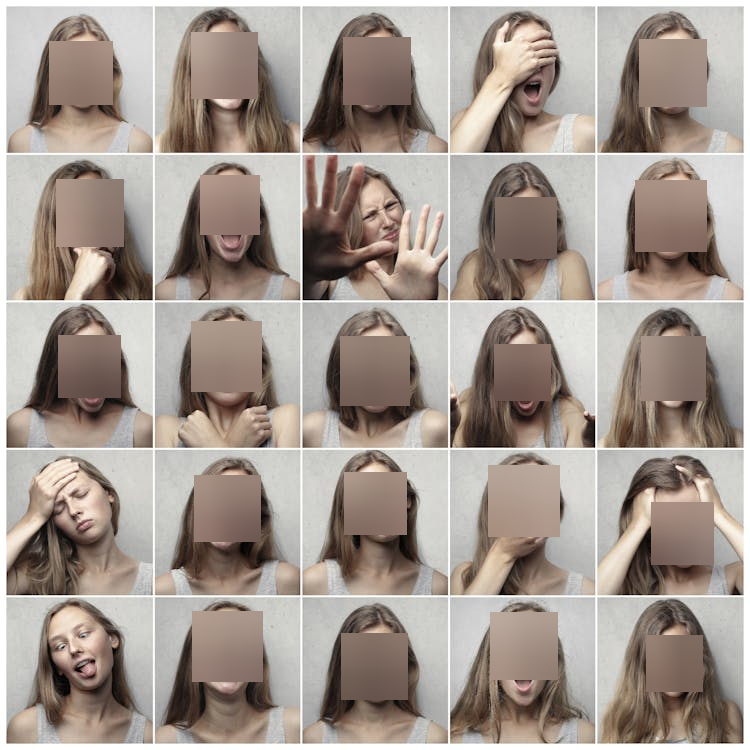

In [20]:
img = get_image('https://images.pexels.com/photos/3812743/pexels-photo-3812743.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')
blur_faces(img)

In [24]:
def pixellate_faces(image, block_size=30):
  # load the Haar cascade for face detection
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # load the image
  img = np.array(image)

  # convert to RBG to BGR (cv2 uses BGR)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  # detection faces
  faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  print(str(len(faces)) + " faces detected.")

  for (x, y, w, h) in faces:
    # select region of interest to blur
    face_roi = img[y:y+h, x:x+w]

    small = cv2.resize(face_roi, (10,10))
    pixelated_roi = cv2.resize(small, (w,h), interpolation=cv2.INTER_NEAREST)

    # Replace the original region of interest with the blurred one
    img[y:y+h, x:x+w] = pixelated_roi

  display_image(img)

21 faces detected.


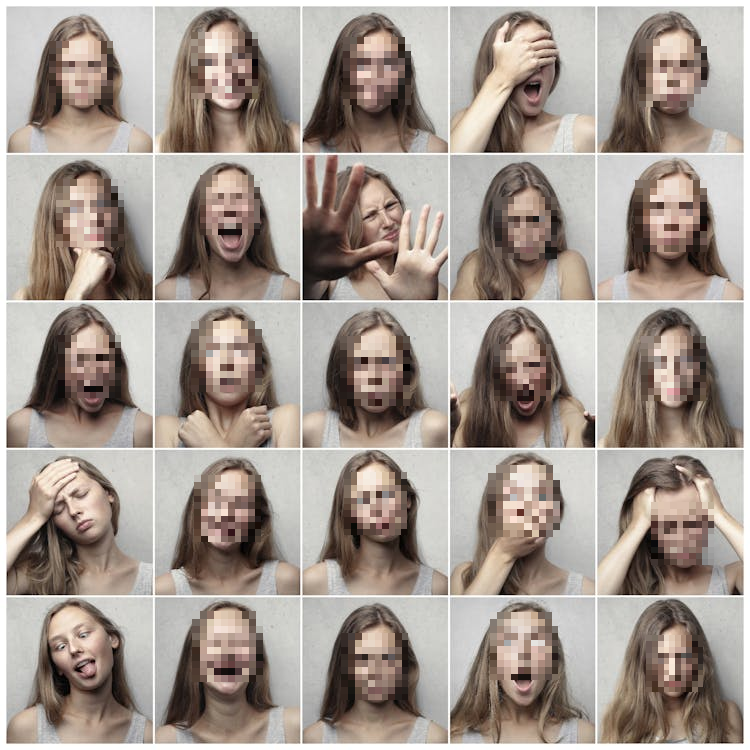

In [25]:
img = get_image('https://images.pexels.com/photos/3812743/pexels-photo-3812743.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')
pixellate_faces(img)

In [27]:
def pixellate_faces_mtcnn(image):
  from mtcnn import MTCNN

  img = np.array(image)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

  detector = MTCNN()
  faces = detector.detect_faces(img)

  print(str(len(faces)) + " faces detected.")

  for face in faces:
    x, y, w, h = face['box']
    face_roi = img[y:y+h, x:x+w]

    small = cv2.resize(face_roi, (10,10))
    pixelated_roi = cv2.resize(small, (w,h), interpolation=cv2.INTER_NEAREST)

    img[y:y+h, x:x+w] = pixelated_roi

  display_image(img)


24 faces detected.


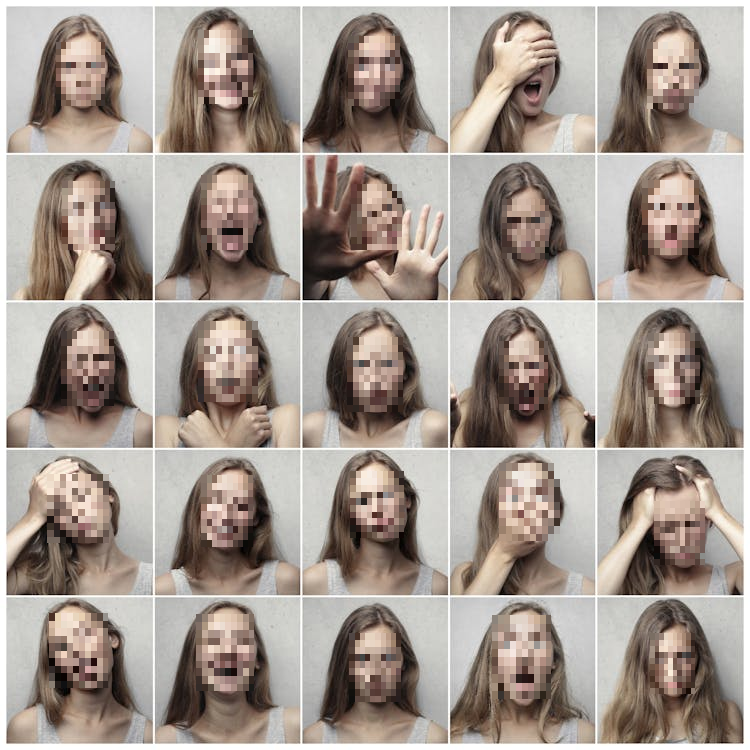

In [28]:
img = get_image('https://images.pexels.com/photos/3812743/pexels-photo-3812743.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1')
pixellate_faces_mtcnn(img)